# Passing the Bechdel Test: Assessing Movies that Include Women
#### Samantha Papadakis | 12/21/2021

## Table of Contents:
1. [**Executive Summary**](#es)
1. [What is the Bechdel Test?](#first-bullet)
1. [What can we learn?](#second-bullet)
1. [**Methods: Cleaning the Data**](#three)
 1. [Data Sets](#3a)
 1. [Bechdel Set](#3b)
 1. [Movie Set](#3c)
 1. [Merge Data](#3d)
1. [Explore relationships in the data](#four)
 1. [Numerical Features](#4a)
 1. [Categorical Features](#4c)
1. [**Results**](#results)
 1. [**Q1. Do movies that pass the test gross more in their release year?**](#q1)
     1. [How has this changed over time?](#q1a)
     
 1. [**Q2. Do movies that pass the test have higher ratings?**](#q2)
     1. [Do critics rate movies that pass the Bechdel test higher than audiences do?](#q2a)
 1. [**Q3. What genres are more likely to pass the Bechdel test?**](#q3)
     1. [Is there a genre-specific difference in revenue or ratings?](#q3a)
 1. [**Q4. Machine Learning: Can we predict whether a movie will pass the Bechdel test based on the above qualities?**](#q4)
1. [Take-Home Messages & Future Directions](#th)
1. [Closing Thoughts](#ct)
 

# Executive Summary<a class="anchor" id="es"></a>

> * **Inequality persists:**
>   * The percent of movies that passed the Bechdel Test _(measures baseline inclusion of women)_ between 2000-2013 has hovered around 60% rather than continuing to increase. [Figure found here.](#pass)
> * Movie producers should **strive to pass the Bechdel Test** for the following reasons: 
>   * No impact on expected gross earnings; may lead to higher earnings if trend persists. [Figure](#earn)
>   * No impact on critic ratings. [Figure](#critic)
>   * No or small impact on audience ratings depending on genre. [Figure](#aud)

# What is the Bechdel Test? <a class="anchor" id="first-bullet"></a>

The Bechdel Test is a low-threshold measure of whether women are represented fairly in fiction. The test was named after Alison Bechdel who first proposed it in a 1985 comic strip. To pass the test, a movie must:

1. Have at least two named women
1. Who talk to each other
1. About something other than a man

While admittedly a low bar, a shocking proportion of today's movies continue to fail this test. This analysis will determine whether there are common features that characterize the movies that tend to do a better job at including women.

# What can we learn? <a class="anchor" id="second-bullet"></a>

This analysis aims to answer a few key questions about movies that pass the Bechdel test.

1. **Do movies that pass the test gross more in their release year?**
1. **Do movies that pass the test have higher ratings?**
1. **What genres are more likely to pass the Bechdel test?**
1. **Machine Learning: Can we predict whether a movie will pass the Bechdel test based on the above qualities?**


# Methods: Cleaning the Data <a class="anchor" id="three"></a>

## Data Sets <a class="anchor" id="3a"></a>
The data sets that will be used in this analysis were sourced from the [Bechdel Test Movie List website](https://bechdeltest.com/) and [FiveThiryEight](https://github.com/fivethirtyeight/data/tree/master/bechdel).

The **first file**, `bechdel.csv`, will give us the unique identifier for each movie (IMDb ID) and its Bechdel score.

Bechdel Score:
> * 0 = lacks two women
> * 1 = has two women, but no talking
> * 2 = two women but only talk about a man
> * 3 = PASSES the full test

A new variable, `Bechdel_pass`, will be created to group the above ratings into two categories:
> * 0 = Fails the Bechdel test (had a value of either 0, 1, or 2 from above)
> * 1 = Passes the Bechdel test (had a value of 3 from above)

The **second file**, `movies.csv`, will give us a variety of other characteristics about the movies.

Key Features:
> * Release Year
> * Budget as of release year, adjusted for inflation using 2013 dollars
> * Domestic gross earnings in release year, adjusted for inflation using 2013 dollars
> * International gross earnings in release year, adjusted for inflation using 2013 dollars
> * Film Rating (e.g. "PG-13")
> * Genre
> * Runtime (in minutes)
> * Rating on IMDb (viewers rate; 10 is best)
> * Metascore (critics rate; 100 is best)

The first step is to load the necessary packages and import the two data sets.

In [1]:
## LOAD PACKAGES

import pandas as pd # to work with data frames
import numpy as np # for working with the data frames
import matplotlib.pyplot as plt # making figures
from pandas.plotting import scatter_matrix # making a matrix of scatter plots
import seaborn as sns # making figures
from scipy.stats import ranksums
#import scipy import stats
import researchpy # t-test
import pingouin as pg # wilcoxon rank-sum test for non-normal data
import statsmodels.formula.api as smf # OLS Regression

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 15] # Make the figures bigger
pd.set_option('display.max_columns', None) # see all the columns when displaying data frame
pd.options.display.float_format = '{:.3f}'.format # setting the number of decimal places
## TO REVERT # pd.reset_option('display.float_format')

In [2]:
## IMPORT THE DATA

df_mov = pd.read_csv('./movies.csv')
df_bechdel = pd.read_csv('./bechdel.csv', encoding='cp1252')

## View and clean the Bechdel data, `df_bechdel`  <a class="anchor" id="3b"></a>

1. Drop all columns except for the IMDb ID (`imdb_id`) and Bechdel Rating (`rating`)
1. Drop all movies that are missing an IMBd ID.
1. Convert the IMBd ID from a 'float' type (unnecessary decimal place) to 'int' (integer) 

In [3]:
df_bechdel.head()

,year,id,imdb_id,title,rating
0,1888,8040,392728.000,Roundhay Garden Scene,0
1,1892,5433,3.000,Pauvre Pierrot,0
2,1895,6200,132134.000,"The Execution of Mary, Queen of Scots",0
3,1895,5444,14.000,Tables Turned on the Gardener,0
4,1896,5406,131.000,Une nuit terrible,0


In [4]:
###### 1. Drop all columns except for the IMDb ID (imdb_id) and Bechdel Rating (rating)

df_bechdel = df_bechdel.drop(["id", "year", "title"], axis=1)
#df_bechdel.head()

In [5]:
###### 2. Drop all movies that are missing an IMBd ID.

# Any NaNs?
print("There are ", df_bechdel['imdb_id'].isna().sum(), " missing values.")

# How long is this dataframe now? Check that it is shortened after dropping the rows with missing values.

print("Length with NaNs: ", len(df_bechdel))
df_bechdel = df_bechdel.dropna()
print("Length without NaNs: ", len(df_bechdel))

There are  4  missing values.
Length with NaNs:  8839
Length without NaNs:  8835


In [6]:
###### 3. Convert the IMBd ID from a 'float' type (unnecessary decimal place) to 'int' (integer)

df_bechdel['imdb_id'] = df_bechdel['imdb_id'].astype("int")

## View and clean the Movie data, `df_mov` <a class="anchor" id="3c"></a>

1. Drop unnecessary columns.
1. Drop all movies that are missing an IMBd ID.
1. Check that each column is the right data type. Change `runtime` to be a numerical value.

In [7]:
df_mov.head()

,year,imdb,title,test,clean_test,binary,budget,domgross,intgross,code,budget_2013,domgross_2013,intgross_2013,period_code,decade_code,imdb_id,plot,rated,response,language,country,writer,metascore,imdb_rating,director,released,actors,genre,awards,runtime,type,poster,imdb_votes,error
0,2013,tt1711425,21 & Over,notalk,notalk,FAIL,13000000,25682380.000,42195766.000,2013FAIL,13000000,25682380.000,42195766.000,1.000,1.000,1711425,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
1,2012,tt1343727,Dredd 3D,ok-disagree,ok,PASS,45000000,13414714.000,40868994.000,2012PASS,45658735,13611086.000,41467257.000,1.000,1.000,1343727,NaN,NaN,NaN,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan
2,2013,tt2024544,12 Years a Slave,notalk-disagree,notalk,FAIL,20000000,53107035.000,158607035.000,2013FAIL,20000000,53107035.000,158607035.000,1.000,1.000,2024544,"In the antebellum United States, Solomon North...",R,True,English,"USA, UK","John Ridley (screenplay), Solomon Northup (bas...",97.000,8.300,Steve McQueen,8-Nov-13,"Chiwetel Ejiofor, Dwight Henry, Dickie Gravois...","Biography, Drama, History",Won 3 Oscars. Another 131 wins & 137 nominations.,134 min,movie,http://ia.media-imdb.com/images/M/MV5BMjExMTEz...,"143,446",nan
3,2013,tt1272878,2 Guns,notalk,notalk,FAIL,61000000,75612460.000,132493015.000,2013FAIL,61000000,75612460.000,132493015.000,1.000,1.000,1272878,A DEA agent and a naval intelligence officer f...,R,True,"English, Spanish",USA,"Blake Masters (screenplay), Steven Grant (base...",55.000,6.800,Baltasar Kormákur,2-Aug-13,"Denzel Washington, Mark Wahlberg, Paula Patton...","Action, Comedy, Crime",1 win.,109 min,movie,http://ia.media-imdb.com/images/M/MV5BNTQ5MTgz...,"87,301",nan
4,2013,tt0453562,42,men,men,FAIL,40000000,95020213.000,95020213.000,2013FAIL,40000000,95020213.000,95020213.000,1.000,1.000,453562,The life story of Jackie Robinson and his hist...,PG-13,True,English,USA,Brian Helgeland,62.000,7.600,Brian Helgeland,12-Apr-13,"Chadwick Boseman, Harrison Ford, Nicole Behari...","Biography, Drama, Sport",3 wins & 13 nominations.,128 min,movie,http://ia.media-imdb.com/images/M/MV5BMTQwMDU4...,"43,608",nan


In [8]:
###### 1. Drop unnecessary columns.

df_mov = df_mov.drop(["imdb", "test", "clean_test", "binary", "budget", "domgross", "intgross",
                      "code", "period_code", "decade_code", "plot", "response", "language",
                      "country", "writer", "director", "released", "actors", "awards", "type",
                      "poster", "imdb_votes", "error"], axis=1)

df_mov.head()

,year,title,budget_2013,domgross_2013,intgross_2013,imdb_id,rated,metascore,imdb_rating,genre,runtime
0,2013,21 & Over,13000000,25682380.000,42195766.000,1711425,NaN,nan,nan,NaN,NaN
1,2012,Dredd 3D,45658735,13611086.000,41467257.000,1343727,NaN,nan,nan,NaN,NaN
2,2013,12 Years a Slave,20000000,53107035.000,158607035.000,2024544,R,97.000,8.300,"Biography, Drama, History",134 min
3,2013,2 Guns,61000000,75612460.000,132493015.000,1272878,R,55.000,6.800,"Action, Comedy, Crime",109 min
4,2013,42,40000000,95020213.000,95020213.000,453562,PG-13,62.000,7.600,"Biography, Drama, Sport",128 min


In [9]:
###### 2. Drop all movies that are missing an IMBd ID (if any).

# Any NaNs?
print("There are ", df_mov['imdb_id'].isna().sum(), " missing values.")

There are  0  missing values.


In [10]:
###### 3. Check that each column is the right data type. Change `runtime` to be a numerical value.
print(df_mov.dtypes)

# Create a new column to store the runtime. First remove " min" from current entries.
df_mov['runtime_min'] = df_mov['runtime'].str[:-4]
# Change NaNs to "0" so that the column can be converted to a numerical value in the next step
df_mov['runtime_min'] = df_mov['runtime_min'].fillna(0)
df_mov['runtime_min'] = df_mov['runtime_min'].astype("int")
# Return the "0" values to NaN
df_mov = df_mov.replace(0, np.nan)
# Remove the original runtime column
df_mov = df_mov.drop(["runtime"], axis=1)
df_mov.head()

year               int64
title             object
budget_2013        int64
domgross_2013    float64
intgross_2013    float64
imdb_id            int64
rated             object
metascore        float64
imdb_rating      float64
genre             object
runtime           object
dtype: object


,year,title,budget_2013,domgross_2013,intgross_2013,imdb_id,rated,metascore,imdb_rating,genre,runtime_min
0,2013,21 & Over,13000000,25682380.000,42195766.000,1711425,NaN,nan,nan,NaN,nan
1,2012,Dredd 3D,45658735,13611086.000,41467257.000,1343727,NaN,nan,nan,NaN,nan
2,2013,12 Years a Slave,20000000,53107035.000,158607035.000,2024544,R,97.000,8.300,"Biography, Drama, History",134.000
3,2013,2 Guns,61000000,75612460.000,132493015.000,1272878,R,55.000,6.800,"Action, Comedy, Crime",109.000
4,2013,42,40000000,95020213.000,95020213.000,453562,PG-13,62.000,7.600,"Biography, Drama, Sport",128.000


## Merge the data frames together and extract new features <a class="anchor" id="3d"></a>

1. Perform an **inner merge** to only keep rows that have an IMDb ID in both data sets
1. Define a function to **create a new column,** `Bechdel_pass`, that turns the Bechdel levels (from `rating`) into either Pass (1) or Fail (0).
1. Create a duplicate dataset that **separates out distinct genres** from the aggregated `genre` column: each movie may appear multiple times, once per each genre category it is a part of.

In [11]:
###### 1. Perform an inner merge to only keep rows that have an IMDb ID in both data sets
data = pd.merge(df_bechdel, df_mov, left_on='imdb_id', right_on='imdb_id')

In [12]:
###### 2. Define a function to create a new column, Bechdel_pass,
######    that turns the Bechdel levels (from rating) into either Pass (1) or Fail (0).

# Define a function that classifies ratings over 2.5 as passing:

def Bechdel_pass (row):
   if row['rating'] > 2.5:
      return 1
   return 0

data['Bechdel_pass'] = data.apply (lambda row: Bechdel_pass(row), axis=1)

data.head()

,imdb_id,rating,year,title,budget_2013,domgross_2013,intgross_2013,rated,metascore,imdb_rating,genre,runtime_min,Bechdel_pass
0,65466,3,1970,Beyond the Valley of the Dolls,5997631,53978683.000,53978683.000,X,nan,6.200,"Comedy, Music",109.000,1
1,67741,1,1971,Shaft,305063707,404702718.000,616827003.000,R,nan,6.600,"Action, Crime, Thriller",100.000,0
2,67992,2,1971,Willy Wonka & the Chocolate Factory,17263543,23018057.000,23018057.000,NaN,nan,nan,NaN,nan,0
3,67116,1,1971,The French Connection,12659931,236848653.000,236848653.000,R,96.000,7.800,"Action, Crime, Thriller",104.000,0
4,67065,1,1971,Escape from the Planet of the Apes,14386286,70780525.000,70780525.000,G,nan,6.200,"Action, Sci-Fi",98.000,0


In [13]:
###### 3. Create a duplicate dataset that separates out distinct genres from the aggregated genre column:
######    each movie may appear multiple times, once per each genre category it is a part of.

## Genre categories are separated by a comma
## After splitting, some genre names started with a space, so remove the space
## What are the unique genres?

data_genre = data
data_genre = data_genre.assign(genre=data_genre['genre'].str.split(',')).explode('genre')
data_genre['genre'] = data_genre['genre'].str.strip()
data_genre['genre'].unique()

array(['Comedy', 'Music', 'Action', 'Crime', 'Thriller', nan, 'Sci-Fi',
       'Horror', 'Drama', 'Family', 'History', 'Western', 'Mystery',
       'Adventure', 'Musical', 'Fantasy', 'Sport', 'War', 'Romance',
       'Biography', 'Animation', 'Documentary'], dtype=object)

## Explore relationships in the data <a class="anchor" id="four"></a>

### Numerical Features<a class="anchor" id="4a"></a>

In [14]:
# First, are there any duplicate movies?

if len(data) == len(data["imdb_id"].unique()):
    print("No duplicate movies.")
else:
    print("Yes, there are duplicates.")

No duplicate movies.


In [15]:
data.describe()

,imdb_id,rating,year,budget_2013,domgross_2013,intgross_2013,metascore,imdb_rating,runtime_min,Bechdel_pass
count,1793.000,1793.000,1793.000,1793.000,1775.000,1782.000,1415.000,1591.000,1590.000,1793.000
mean,596564.611,2.139,2002.547,55471775.093,95213303.906,197928395.120,59.027,6.761,111.001,0.554
std,557429.212,1.046,8.979,54933117.612,125990383.462,283561817.602,17.216,0.962,20.913,0.497
min,35423.000,0.000,1970.000,8632.000,899.000,899.000,11.000,2.100,55.000,0.000
25%,120828.000,1.000,1998.000,16031507.000,20520938.500,33131158.250,47.000,6.200,97.000,0.000
50%,372532.000,3.000,2005.000,36995786.000,56022212.000,96276482.000,60.000,6.800,107.000,1.000
75%,1001526.000,3.000,2009.000,78450540.000,121696769.000,241485618.750,72.000,7.400,122.000,1.000
max,2425486.000,3.000,2013.000,461435929.000,1771682790.000,3171930973.000,100.000,9.300,271.000,1.000


### Evaluate data distributions

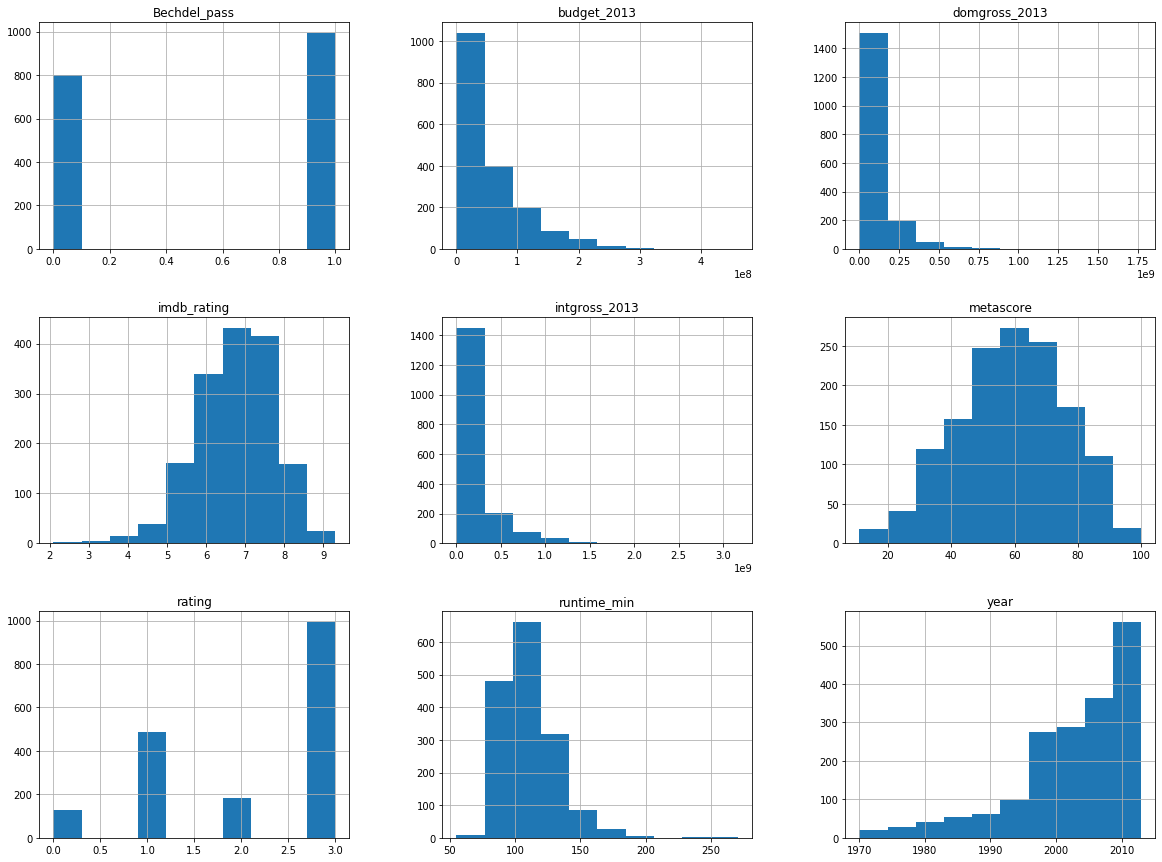

In [16]:
# exclude the ID column
data.drop(["imdb_id"], axis=1).hist();

#### Immediate Observations

1. Roughly 45% of 1,793 total movies sampled FAIL the Bechdel test (see Bechdel_pass histogram).
1. The domestic gross revenue feature, `domgross_2013`, is skewed right. It might be interesting to see if the top-grossing movies have a different Bechdel passing rate.
1. The two viewer rating scores, `imdb_rating` and `metascore`, are both roughly normally distributed, meaning there is a balanced spread of good and bad movies. However, there are some missing data points (see counts < 1793). Roughly 89% of the `imdb_rating` values are there, so the missing values could be ignored or imputed.
 1. Could `metascore` be used to impute the missing values in `imdb_rating`?

In [17]:
# Could `metascore` be used to impute the missing values in `imdb_rating`?

# Are there any rows where an `imdb_rating` value is missing but the `metascore` value is present?
counter = 0
for i in range(len(data)):
    if pd.isna(data.loc[i,'imdb_rating']):
        if pd.isna(data.loc[i,'imdb_rating']) != pd.isna(data.loc[i,'metascore']):
            counter = counter+1
if counter < 10:
    print("No, there are ", counter, " replacement opportunities. Nevermind.")
else:
    print("Sure, there are ",counter, " replacement opportunities. Now determine if the features are highly correlated enough to merit imputation.")


No, there are  0  replacement opportunities. Nevermind.


### Examine relationships between continuous variables<a class="anchor" id="4b"></a>

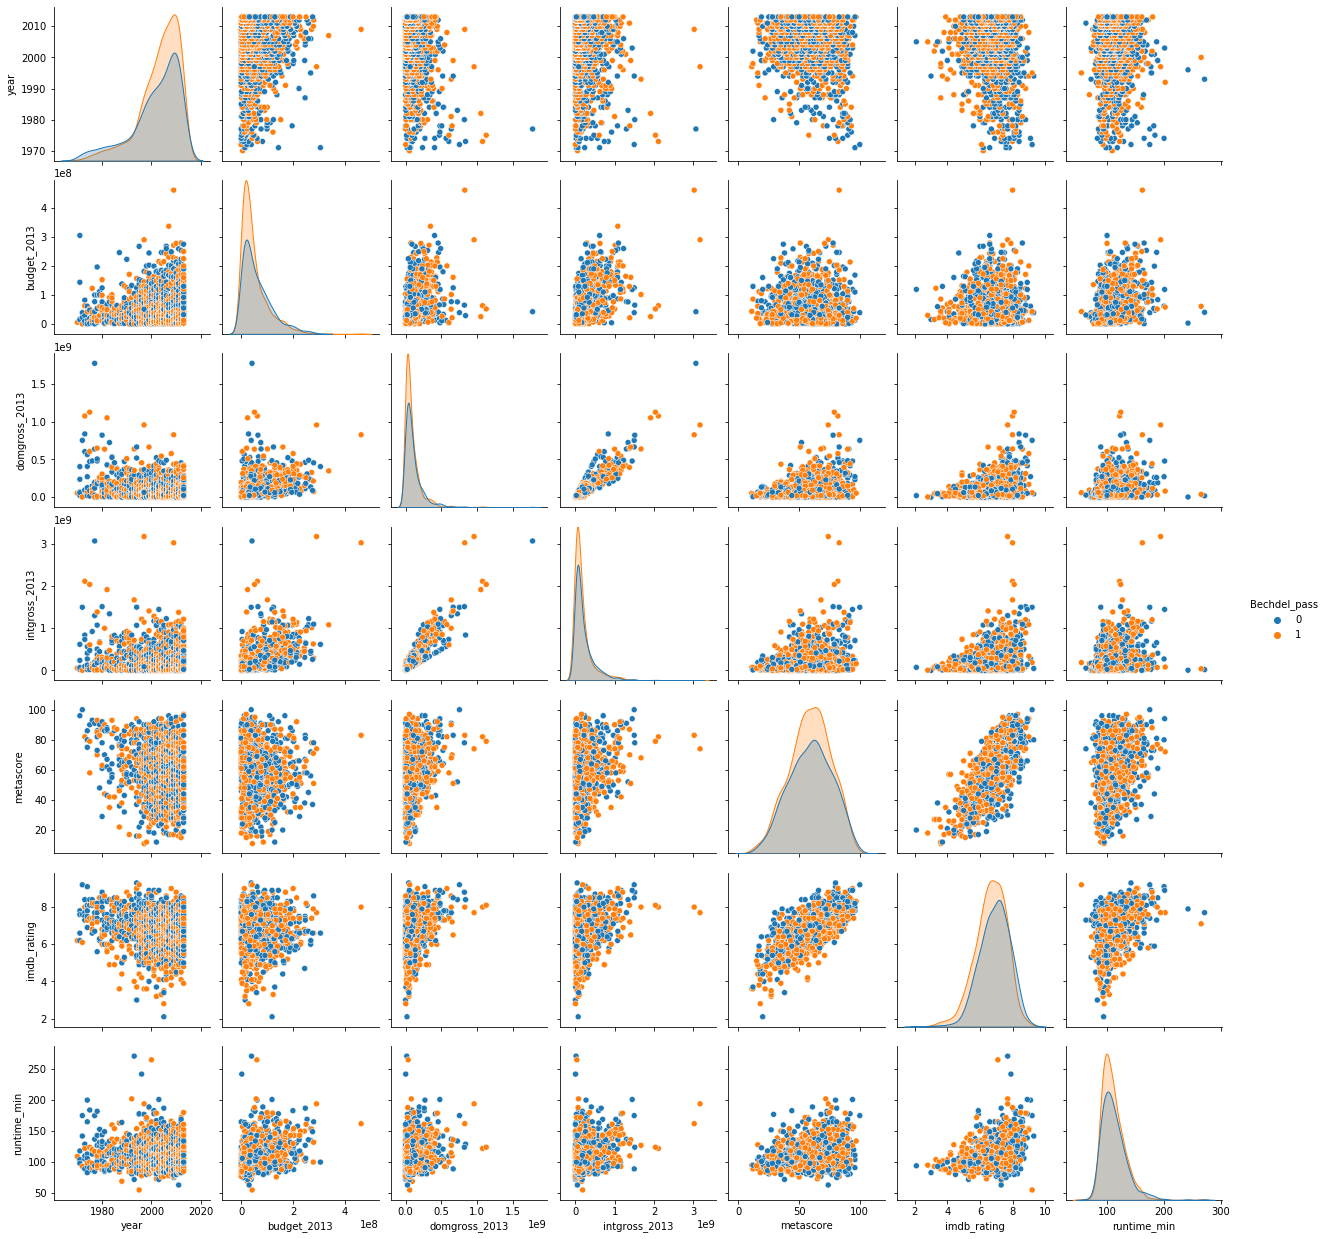

In [18]:
sns.pairplot(data.drop(["imdb_id", "rating"], axis=1), hue='Bechdel_pass');

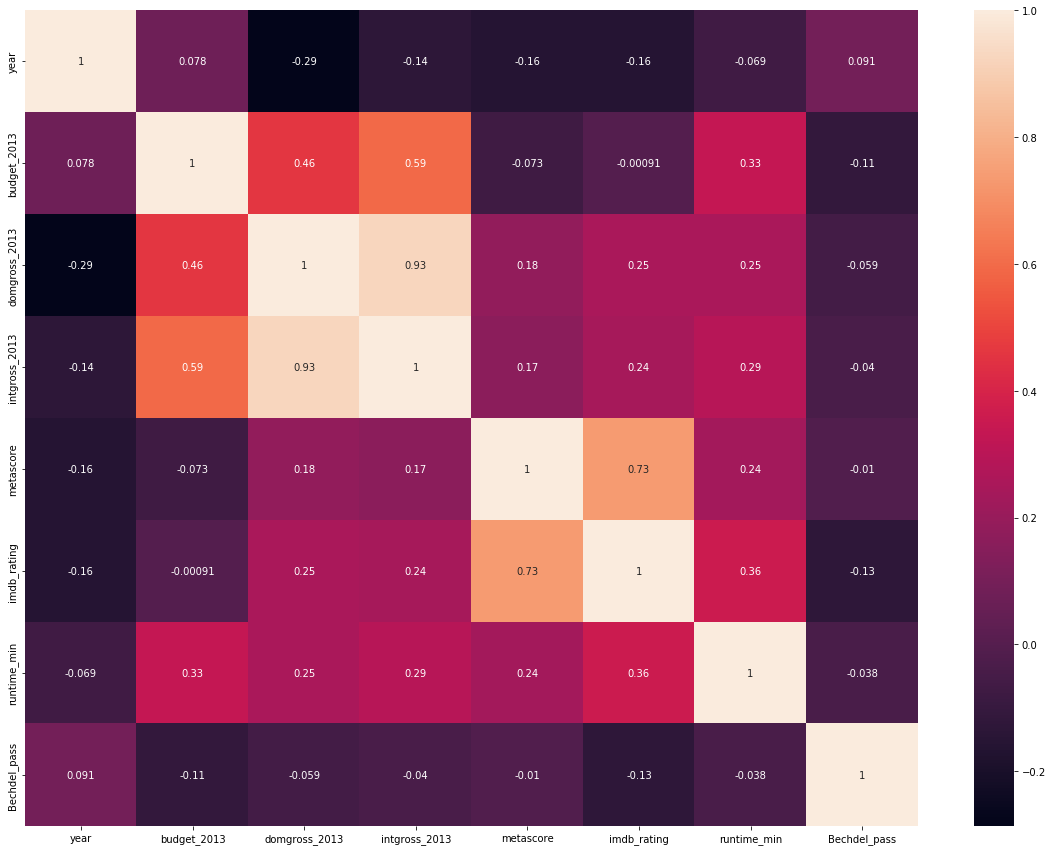

In [19]:
# Summarize the above relationships with their correlation coefficients
corrMatrix = data.drop(["imdb_id", "rating"], axis=1).corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

#### Immediate Observations

1. `Bechdel_pass` does not strongly correlate to any metric of interest. The highest correlation is with `imdb_rating` with a weak correlation coefficient of -0.13, followed by `budget_2013` with a weak correlation coefficient of -0.11.
1. When observing the histograms along the diagonal of the scatter matrix, the peaks for both values of `Bechdel_pass` seem roughly aligned, indicating that there might not be a significant difference in any feature between movies that do and do not pass the Bechdel test. The one exception might be with `imdb_rating`, where the distribution of movies that pass seem to fall lower on the rating scale than movies that fail, as indicated by the weak correlation coefficient of -0.13. 
1. The release `year` correlates weakly and negatively with several economic metrics and viewer ratings.
1. `imdb_rating` and `metascore` correlate well, but the scatterplot subtly implies that for any given rating by a critic (`metascore`), an average viewer (`imdb_rating`) is going to rate a movie that passes the Bechdel Test lower.

### Categorical Features<a class="anchor" id="4c"></a>

In [20]:
data.describe(include=[object])

,title,rated,genre
count,1793,1581,1591
unique,1767,10,271
top,Pride and Prejudice,R,"Comedy, Drama, Romance"
freq,3,691,65


Film Ratings: Number of observations per each.
 R            691
PG-13        564
PG           257
G             36
Not Rated     15
NC-17          7
Unrated        5
X              4
TV-PG          1
TV-14          1
Name: rated, dtype: int64 


Genres: Number of observations per each.
 Drama          739
Comedy         559
Action         442
Adventure      359
Thriller       304
Crime          258
Romance        238
Sci-Fi         204
Fantasy        180
Horror         171
Mystery        143
Animation      108
Family         107
Biography       77
History         49
Music           37
War             29
Sport           28
Musical         21
Western         12
Documentary      4
Name: genre, dtype: int64


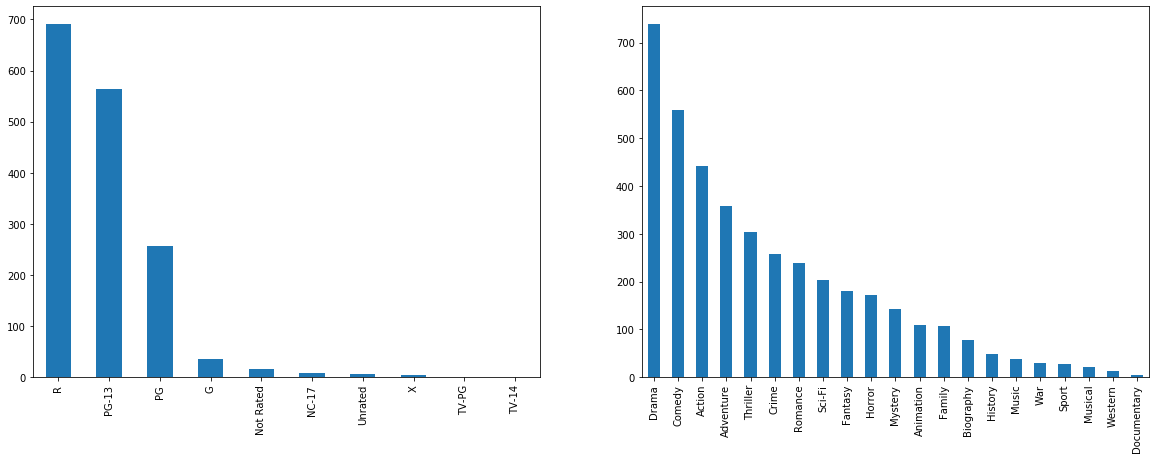

In [21]:
# View number of movies per each Film Rating and Genre (genre viewed in duplicated data set)
plt.subplot(221)
data['rated'].value_counts().plot(kind='bar')
plt.subplot(222)
data_genre['genre'].value_counts().plot(kind='bar')

table = data['rated'].value_counts()
print("Film Ratings: Number of observations per each.\n", table, "\n\n")
table = data_genre['genre'].value_counts()
print("Genres: Number of observations per each.\n", table)

#### Immediate Observations

1. There are fewer than 50 observations in some of the categories, which might merit category exclusion.
 1. Film Ratings: Only include R, PG-13, and PG. 
 1. Genres: Exclude History, Music, War, Sport, Musical, Western, and Documentary.

# Results <a class="anchor" id="results"></a>

## Q1. Do movies that pass the test gross more in their release year?<a class="anchor" id="q1"></a>

> ### No. There is no meaningful difference in domestic gross revenue between movies that pass the Bechdel test and movies that fail.

**Rationale:**

While the independent t-test yielded a statistically significant result (p=0.013), suggesting that movies that pass the Bechdel test perform worse at the box office, the effect size was too small to conclude that the difference was meaningful (Cohen's d = 0.119; it should be above 0.2 at minimum to demonstrate a small effect).

This is demonstrated visually, as the histograms and boxplots show substantial overlap.

> * Test: Independent t-test
> * P-value: 0.013
> * Effect size: 0.119
> * Number of movies (N): 1775
> * Range of Years: 1970-2013

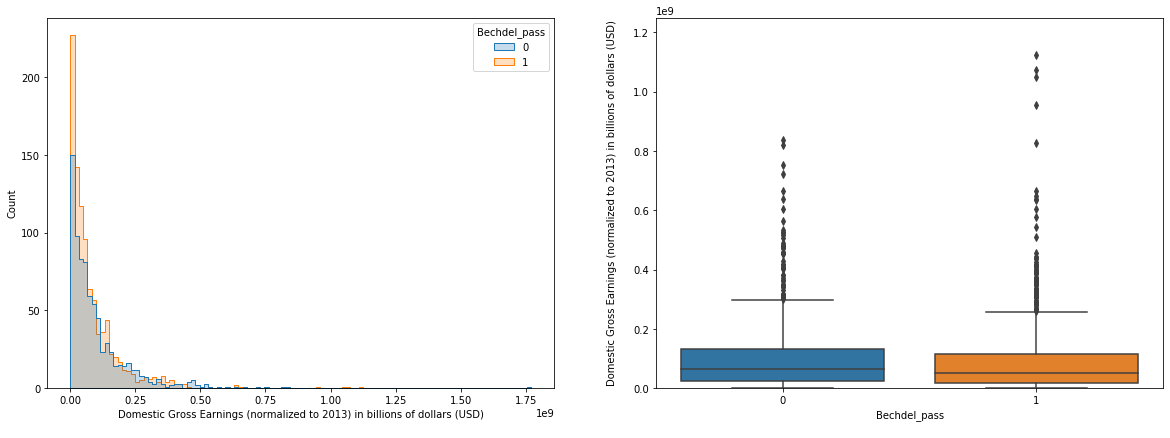

In [22]:
plt.subplot(221)
sns.histplot(data, x="domgross_2013", hue="Bechdel_pass", element="step").set(
    xlabel= 'Domestic Gross Earnings (normalized to 2013) in billions of dollars (USD)\n')
plt.subplot(222)
plt.ylim(0, 1250000000) ## Excludes one outlier (Bechdel_pass=0) to make the boxplots more visible
sns.boxplot(x="Bechdel_pass", y="domgross_2013", data=data).set(
    ylabel= 'Domestic Gross Earnings (normalized to 2013) in billions of dollars (USD)\n');

In [23]:
chart = data.groupby('Bechdel_pass')['domgross_2013'].describe()
table = pd.DataFrame(chart)
table

,count,mean,std,min,25%,50%,75%,max
Bechdel_pass,,,,,,,,
0,793.000,103490846.130,132851080.481,899.000,24664310.000,64220970.000,133670224.000,1771682790.000
1,982.000,88528893.536,119816292.871,9824.000,18307311.500,51534708.000,114630823.500,1125306085.000


#### **Above:** Descriptive Statistics about the domestic gross earnings (USD) in the release year, normalized to 2013, of movies that fail (Bechdel_pass=0) and pass (Bechdel_pass=1) the Bechdel Test.
The mean and median ("50%") indicate that movies that pass the Bechdel test gross less than movies that fail the test by about $12-15 million on average, a comparatively small amount.

In [24]:
print(researchpy.ttest(data['domgross_2013'].loc[data['Bechdel_pass'] <0.5], data['domgross_2013'].loc[data['Bechdel_pass'] > 0.5])[1])
print("\nWilcoxon rank-sum test p-value =",
      ranksums(data['domgross_2013'].loc[data['Bechdel_pass'] <0.5], data['domgross_2013'].loc[data['Bechdel_pass'] > 0.5])[1])

                              Independent t-test      results
0  Difference (domgross_2013 - domgross_2013) =  14961952.594
1                          Degrees of freedom =      1773.000
2                                           t =         2.491
3                       Two side test p value =         0.013
4                      Difference < 0 p value =         0.994
5                      Difference > 0 p value =         0.006
6                                   Cohen's d =         0.119
7                                   Hedge's g =         0.119
8                               Glass's delta =         0.113
9                                 Pearson's r =         0.059

Wilcoxon rank-sum test p-value = 0.0015857386060955001


#### **Above:** Statistical Output.
A t-test is designed for normal distributions, but it is generally still suitable for non-normal distributions with large sample sizes. The gross earnings distribution is not normal, so a Wilcoxon rank-sum test, which is a non-parametric test designed for non-normal distributions, was performed to confirm that the t-test result was valid.

## How has this changed over time?<a class="anchor" id="q1a"></a>

This data set spans movies from 1970 through 2013, which is a period of 43 years. Perhaps times have changed. Is a movie that passes the Bechdel test more likely to do better at the box office today than in the past?

### First follow-up question: Are more movies passing the Bechdel test over time? (see histogram, below)
Yes. A greater proportion of movies pass the Bechdel Test in more recent years. This indicates that there is a growing trend towards including women in movies. However, that trend may have started to plateau in the early 2000's.

**Rationale:**

While an independent t-test yielded a statistically significant result (p<0.001), it is important to keep in mind that the effect size was still small (Cohen's d = 0.183).<a class="anchor" id="pass"></a>

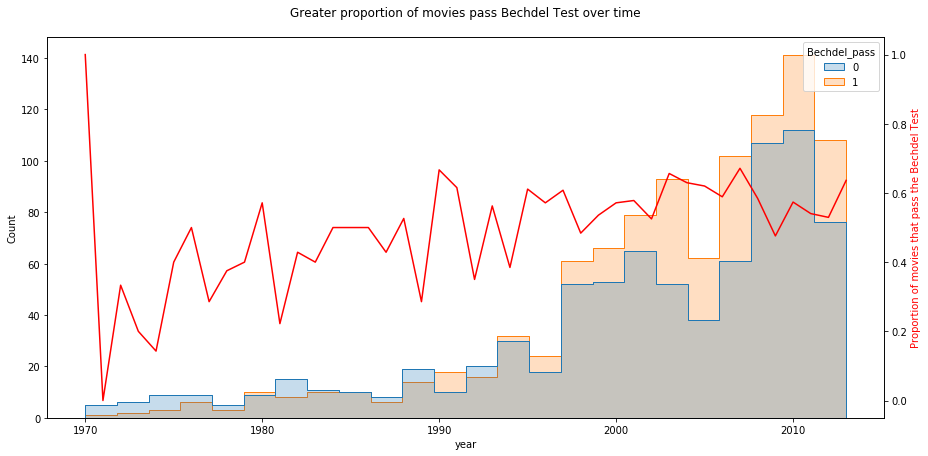

In [25]:
plt.rcParams['figure.figsize'] = [15, 7] # Make the figures bigger
sns.histplot(data, x="year", hue="Bechdel_pass", element="step").set(
    title='Greater proportion of movies pass Bechdel Test over time\n')
ax2 = plt.twinx()
year_bratio = list(range(len(data['year'].unique())))

## Find the proportion of movies that pass the Bechdel test each year and plot it
for i in range(len(data['year'].unique())):
    newdata=data[data['year'] == i+1970]
    if i==1:
        year_bratio[i] = 0/len(newdata)
    else:
        year_bratio[i] = (newdata['Bechdel_pass'].value_counts()[1])/(len(newdata))
plt.plot(range(1970,1970+len(year_bratio)), year_bratio, color='r')
ax2.set_ylabel('Proportion of movies that pass the Bechdel Test', color='r');

In [26]:
researchpy.ttest(data['year'].loc[data['Bechdel_pass'] <0.5], data['year'].loc[data['Bechdel_pass'] > 0.5])[1]

,Independent t-test,results
0,Difference (year - year) =,-1.638
1,Degrees of freedom =,1791.000
2,t =,-3.854
3,Two side test p value =,0.000
4,Difference < 0 p value =,0.000
5,Difference > 0 p value =,1.000
6,Cohen's d =,-0.183
7,Hedge's g =,-0.183
8,Glass's delta =,-0.166
9,Pearson's r =,0.091


### Second follow-up question: Do movies that pass the Bechdel Test gross more in their release year at any point in time? Is there a trend? (see scatter plot)
Yes, possibly. In general, there is a decreasing trend indicating that older movies grossed more in their release year than more recent movies. While this trend does not seem to differ between movies that do and do not pass the Bechdel test (see the similar slope of the trend lines), the difference is statistically significant. The slopes indicate that movies that fail the Bechdel test will not have as steep of an earnings margin over movies that pass in future years.

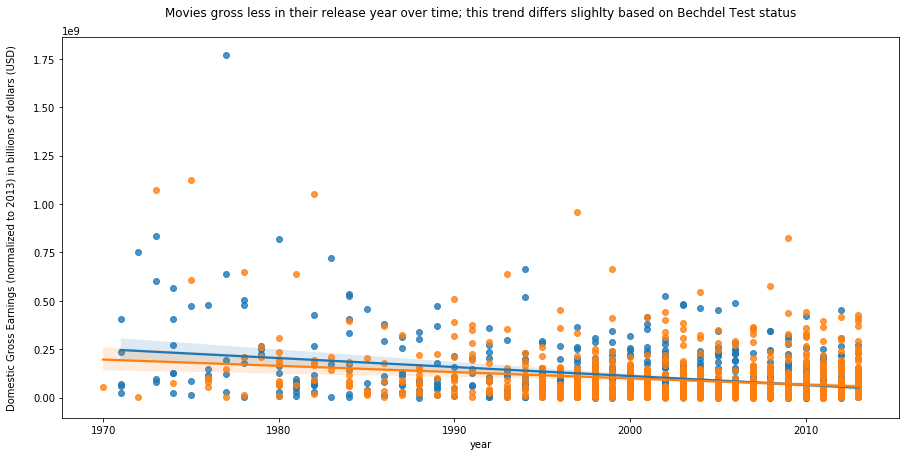

In [27]:
sns.regplot(x="year", y="domgross_2013", data=data[data['Bechdel_pass']==0])
sns.regplot(x="year", y="domgross_2013", data=data[data['Bechdel_pass']==1]).set(
title='Movies gross less in their release year over time; this trend differs slighlty based on Bechdel Test status\n',
    ylabel= 'Domestic Gross Earnings (normalized to 2013) in billions of dollars (USD)\n');

**Rationale:**

The regression model used in this analysis tested the following formula:
> Domestic Gross Earnings _predicted by_ Release Year + Bechdel Test + (Interaction between Year and Bechdel) + Budget + (Interaction between Year and Budget)

In simpler terms, this formula takes into account the fact that a movie's domestic gross earnings might be influenced by the movie's budget and release year (recall the weak correlations observed above), so it controls for those factors when evaluating whether passing the Bechdel test had an added predictive effect beyond those variables. 

When testing for a difference in slope using an ordinary least squares (OLS) regression model, the interaction between year and Bechdel test status is significant (p=0.003; no main effect of budget or interaction effect between budget and year), indicating that there is a difference in the slope of gross earnings between movies that do and do not pass the Bechdel test for movies between 1970 and 2013. However, it is possible that this difference is small enough to be negligible, espcially given the high variability in gross earnings across a small number of movies in the older years.

When **excluding the oldest years in the sample** (years 1970-1975, in which no year had yet released more than 7 movies in the sample), the interaction effect **remained significant** (p<0.001; no main effect of budget or interaction effect between budget and year), as did the significance level of the main effect of the Bechdel test on domestic gross earnings independent of year (p<0.001).

When looking at **the most recent 14 years** (years 2000-2013, in which each year had a sample of at least 63 movies), there continues to be a main effect of Bechdel test status and an interaction effect between Bechdel test status and year (p=0.024 and p=0.023 repesctively), as well as a main effect of budget and an interaction effect between budget and year (p<0.001 for each).

A plot of the slopes over the more recent years (see below) tells an **interesting story.**<a class="anchor" id="earn"></a>
> Although it was established earlier that the difference in gross earnings between movies that do and do not pass the Bechdel test was negligible, viewing the gross earnings across time adds another layer of meaning. **In the past, movies that fail the Bechdel test tend to have higher gross earnings than movies that pass,** and a close-up view of the last 14 years in the data set (2000-2013) reveals how **this profit margin is disappearing over time.** While movies that pass the Bechdel test are maintaining their level of domestic gross earnings with each new year, movies that fail the test are losing their edge and are potentially becoming **less profitable** as time goes on. However, despite the statistical significance of these findings, the differences in the slopes are too small to provide a robust prediction of future earnings. 

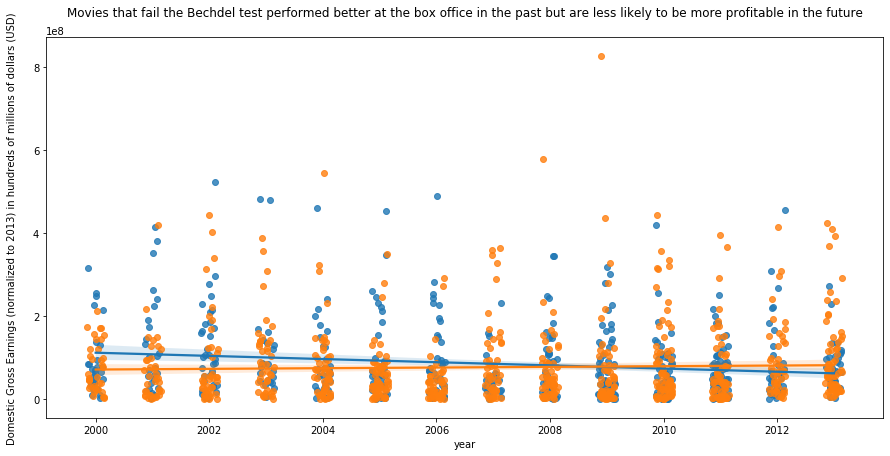

In [28]:
newdata=data[data['year'] > 1999]
sns.regplot(x="year", y="domgross_2013", data=newdata[newdata['Bechdel_pass']==0], x_jitter=0.15)
sns.regplot(x="year", y="domgross_2013", data=newdata[newdata['Bechdel_pass']==1], x_jitter=0.15).set(
title='Movies that fail the Bechdel test performed better at the box office in the past but are less likely to be more profitable in the future\n',
    ylabel= 'Domestic Gross Earnings (normalized to 2013) in hundreds of millions of dollars (USD)\n');

In [29]:
## Change "1969" to any year to see the regression results for the period between that year and 2013.
lm1 = smf.ols(formula='domgross_2013 ~ year * Bechdel_pass + budget_2013 * year', data=data[data['year'] > 1969]).fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          domgross_2013   R-squared:                       0.322
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     168.3
Date:                Tue, 21 Dec 2021   Prob (F-statistic):          1.19e-146
Time:                        04:03:15   Log-Likelihood:                -35280.
No. Observations:                1775   AIC:                         7.057e+04
Df Residuals:                    1769   BIC:                         7.060e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.141e+10   9.31e+08     12.257      0.000    9.59e+09    1.32e+10
year              -5.684e+06   4.65e+05    -12.224      0.000    -6.6e+06   -4.77e+06
Bechdel_pass      -3.275e+09   1.11e+09     -2.947      0.003   -5.45e+09    -1.1e+09
year:Bechdel_pass  1.639e+06   5.55e+05      2.953      0.003     5.5e+05    2.73e+06
budget_2013         -11.8844     10.653     -1.116      0.265     -32.778       9.009
budget_2013:year      0.0065      0.005      1.221      0.222      -0.004       0.017
==============================================================================
Omnibus:                     1693.420   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           133879.047
Skew:                           4.271   Prob(JB):                         0.00
Kurtosis:                      44.680   Cond. No.                     8.26e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.26e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Conclusion: Movies that pass the Bechdel Test have roughly equivalent domestic gross earnings to movies that fail when aggregating across time, but an emerging trend suggests that movies that fail the test will be less profitable in the future.
_________________________________________________________

## Q2. Do movies that pass the test have higher ratings?<a class="anchor" id="q2"></a>

> ### No. Movies that pass the Bechdel test are associated with lower audience ratings and equivalent critic ratings.

**Rationale:**

**IMDb ratings (audience ratings):**
The independent t-test yielded a statistically significant result (p<0.001) and the effect size was weak (Cohen's d = 0.258), indicating that there is truly a small difference in IMDb ratings between movies that do and do not pass the Bechdel test. The movies that pass the Bechdel test are rated lower.

This is demonstrated visually, as the histograms and boxplots show the movies that pass the test slightly lower on the rating scale.

> * Test: Independent t-test
> * P-value: < 0.001
> * Effect size: 0.258
> * Number of movies (N): 1591
> * Range of Years: 1970-2013

**Metascore ratings (critic ratings):** <a class="anchor" id="critic"></a>
The independent t-test yielded a non-significant result (p>0.05), indicating that there is no difference in metascore ratings between movies that do and do not pass the Bechdel test.

This is demonstrated visually, as the histograms and boxplots show no difference in ratings between the movies that do and do not pass the test.

> * Test: Independent t-test
> * P-value: 0.705
> * Number of movies (N): 1591
> * Range of Years: 1970-2013

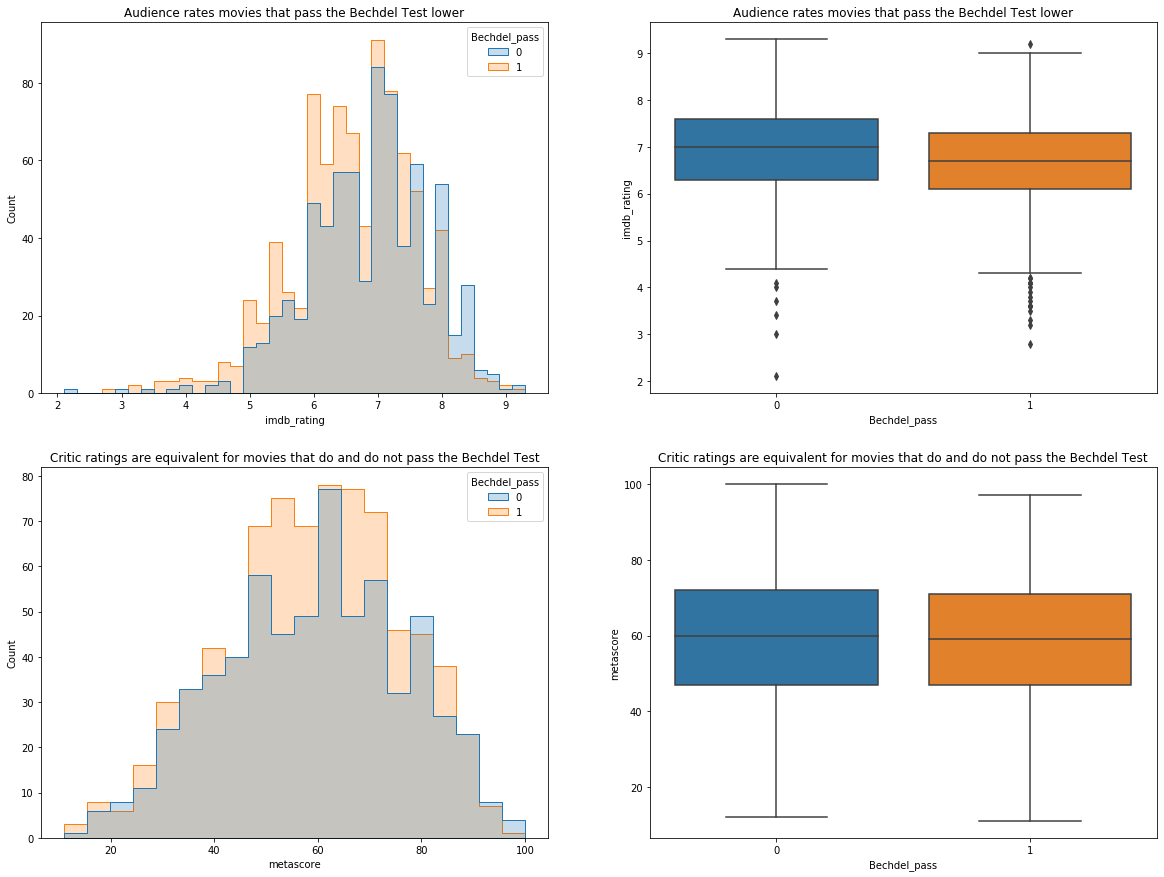

In [30]:
plt.rcParams['figure.figsize'] = [20, 15] # Make the figures bigger
plt.subplot(221)
sns.histplot(data, x="imdb_rating", hue="Bechdel_pass", element="step").set(title= "Audience rates movies that pass the Bechdel Test lower")
plt.subplot(222)
sns.boxplot(x="Bechdel_pass", y="imdb_rating", data=data).set(title= "Audience rates movies that pass the Bechdel Test lower")

plt.subplot(223)
sns.histplot(data, x="metascore", hue="Bechdel_pass", element="step").set(title= "Critic ratings are equivalent for movies that do and do not pass the Bechdel Test")
plt.subplot(224)
sns.boxplot(x="Bechdel_pass", y="metascore", data=data).set(title= "Critic ratings are equivalent for movies that do and do not pass the Bechdel Test");

In [31]:
chart = data.groupby('Bechdel_pass')['imdb_rating','metascore'].describe()
table = pd.DataFrame(chart)
table

imdb_rating                                           metascore  \
                   count  mean   std   min   25%   50%   75%   max     count   
Bechdel_pass                                                                   
0                726.000 6.895 0.941 2.100 6.300 7.000 7.600 9.300   637.000   
1                865.000 6.649 0.967 2.800 6.100 6.700 7.300 9.200   778.000   

                                                                
               mean    std    min    25%    50%    75%     max  
Bechdel_pass                                                    
0            59.218 17.603 12.000 47.000 60.000 72.000 100.000  
1            58.870 16.902 11.000 47.000 59.000 71.000  97.000

In [32]:
print("IMDb Rating:\n",
researchpy.ttest(data['imdb_rating'].loc[data['Bechdel_pass'] <0.5], data['imdb_rating'].loc[data['Bechdel_pass'] > 0.5])[1],
"\n\nMetascore Rating:\n",
researchpy.ttest(data['metascore'].loc[data['Bechdel_pass'] <0.5], data['metascore'].loc[data['Bechdel_pass'] > 0.5])[1])

IMDb Rating:
                           Independent t-test  results
0  Difference (imdb_rating - imdb_rating) =     0.246
1                      Degrees of freedom =  1589.000
2                                       t =     5.129
3                   Two side test p value =     0.000
4                  Difference < 0 p value =     1.000
5                  Difference > 0 p value =     0.000
6                               Cohen's d =     0.258
7                               Hedge's g =     0.258
8                           Glass's delta =     0.262
9                             Pearson's r =     0.128 

Metascore Rating:
                       Independent t-test  results
0  Difference (metascore - metascore) =     0.348
1                  Degrees of freedom =  1413.000
2                                   t =     0.378
3               Two side test p value =     0.705
4              Difference < 0 p value =     0.647
5              Difference > 0 p value =     0.353
6                    

## Do critics rate movies that pass the Bechdel test higher than audiences do?<a class="anchor" id="q2a"></a>

> ### Yes.

**Rationale:**

An independent t-test comparing the scores of movies that pass the Bechdel test yielded a statistically significant result (p<0.001) and a strong effect size (Cohen's d = 4.482), indicating that critics rate these movies higher than audience members do.

In [33]:
researchpy.ttest(data['imdb_rating'].loc[data['Bechdel_pass'] >0.5], data['metascore'].loc[data['Bechdel_pass'] > 0.5])[1]

,Independent t-test,results
0,Difference (imdb_rating - metascore) =,-52.222
1,Degrees of freedom =,1641.000
2,t =,-90.706
3,Two side test p value =,0.000
4,Difference < 0 p value =,0.000
5,Difference > 0 p value =,1.000
6,Cohen's d =,-4.482
7,Hedge's g =,-4.480
8,Glass's delta =,-54.029
9,Pearson's r =,0.913


The following kernel density estimate (KDE) plot demonstrates how audience and critic ratings are highly correlated, and the audience rating (`imdb_rating`) of a movie that passes the Bechdel Test tends to be lower than its critic rating (`metascore`).

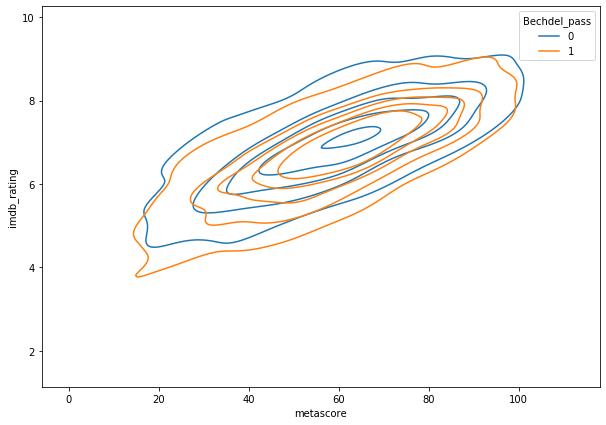

In [34]:
plt.rcParams['figure.figsize'] = [10, 7]
sns.kdeplot(data=data, x="metascore", y="imdb_rating", hue="Bechdel_pass", levels=6);

## Conclusion: Audience members rate movies that pass the Bechdel test lower than movies that fail, and their rating for any given movie that passes the Bechdel test is lower than the rating a critic would give that movie.
____________________________

## Q3. What genres are more likely to pass the Bechdel Test? <a class="anchor" id="q3"></a>

> ### Top 3: Horror, Romance, Family
> ### Bottom 3: Crime, Action, Animation

**Rationale:**

After excluding genres that had fewer than 50 observations (see histogram), a bar plot showing the average `Bechdel_pass` score revealed which genres passed and failed the Bechdel test the most (see plot). Interestingly, the Horror genre ranked first with almost 70% of all horror films passing the Bechdel test.

An independent t-test comparing the test scores of the Horror and Crime genres yielded a statistically significant result (p<0.001) with a strong effect size (Cohen's d = 0.659), indicating that there is a difference in the percent of movies that pass the Bechdel test between the two genres at the extreme ends of the spectrum.

There was no significant difference in passing the Bechdel test between Horror movies and movies in each of the following genres, suggesting that all of these genres pass the Bechdel test at similar rates: Horror, Romance, Family, Biography, Comedy.

Genres with fewer than 50 observations, to be ignored:
 Index(['History', 'Music', 'War', 'Sport', 'Musical', 'Western',
       'Documentary'],
      dtype='object')


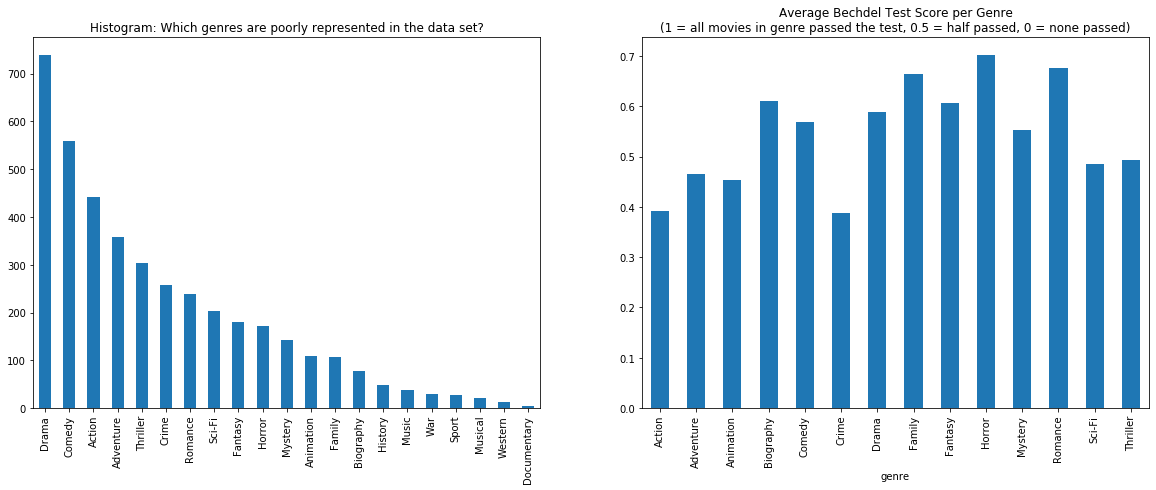

In [35]:
table = data_genre['genre'].value_counts()
newlist = table[table[:]<50].index
newlist2 = newlist.tolist()
print("Genres with fewer than 50 observations, to be ignored:\n",newlist)

def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]
data_moregen = filter_rows_by_values(data_genre, "genre", newlist2)

plt.rcParams['figure.figsize'] = [20, 15]
plt.subplot(221)
data_genre['genre'].value_counts().plot(kind='bar')
plt.title("Histogram: Which genres are poorly represented in the data set?")

plt.subplot(222)
data_moregen.groupby('genre')['Bechdel_pass'].mean().plot(kind='bar')
plt.title("Average Bechdel Test Score per Genre\n(1 = all movies in genre passed the test, 0.5 = half passed, 0 = none passed)");

In [36]:
print("Horror vs. Crime:\n",researchpy.ttest(data_moregen['Bechdel_pass'].loc[data_moregen['genre']=='Horror'],
                 data_moregen['Bechdel_pass'].loc[data_moregen['genre']=='Crime'])[1])
#print("\nHorror vs. Fantasy:\n",researchpy.ttest(data_moregen['Bechdel_pass'].loc[data_moregen['genre']=='Horror'],
#                 data_moregen['Bechdel_pass'].loc[data_moregen['genre']=='Fantasy'])[1])

Horror vs. Crime:
                             Independent t-test  results
0  Difference (Bechdel_pass - Bechdel_pass) =     0.314
1                        Degrees of freedom =   427.000
2                                         t =     6.683
3                     Two side test p value =     0.000
4                    Difference < 0 p value =     1.000
5                    Difference > 0 p value =     0.000
6                                 Cohen's d =     0.659
7                                 Hedge's g =     0.658
8                             Glass's delta =     0.685
9                               Pearson's r =     0.308


## Is there a _genre-specific_ difference in revenue or ratings between movies that do and do not pass the Bechdel Test?<a class="anchor" id="q3a"></a>

### Domestic Gross Earnings

Genres that show **lower domestic gross earnings** for movies that pass the Bechdel test include the following:

> * Comedy (p=0.002, Cohen's d = 0.272)
> * Drama (p=0.009, Cohen's d = 0.198)
> * Biography (p=0.033, Cohen's d = 0.510)


### Audience Ratings (IMDb)

Genres that show **lower IMDb ratings** for movies that pass the Bechdel test include the following:

> * Comedy (p=0.002, Cohen's d = 0.263)
> * Action (p=0.047, Cohen's d = 0.194)
> * Thriller (p=0.002, Cohen's d = 0.368)
> * Horror (p=0.041, Cohen's d = 0.345)
> * Drama (p<0.001, Cohen's d = 0.360)
> * Mystery (p=0.026, Cohen's d = 0.380)
> * Fantasy (p=0.004, Cohen's d = 0.441)


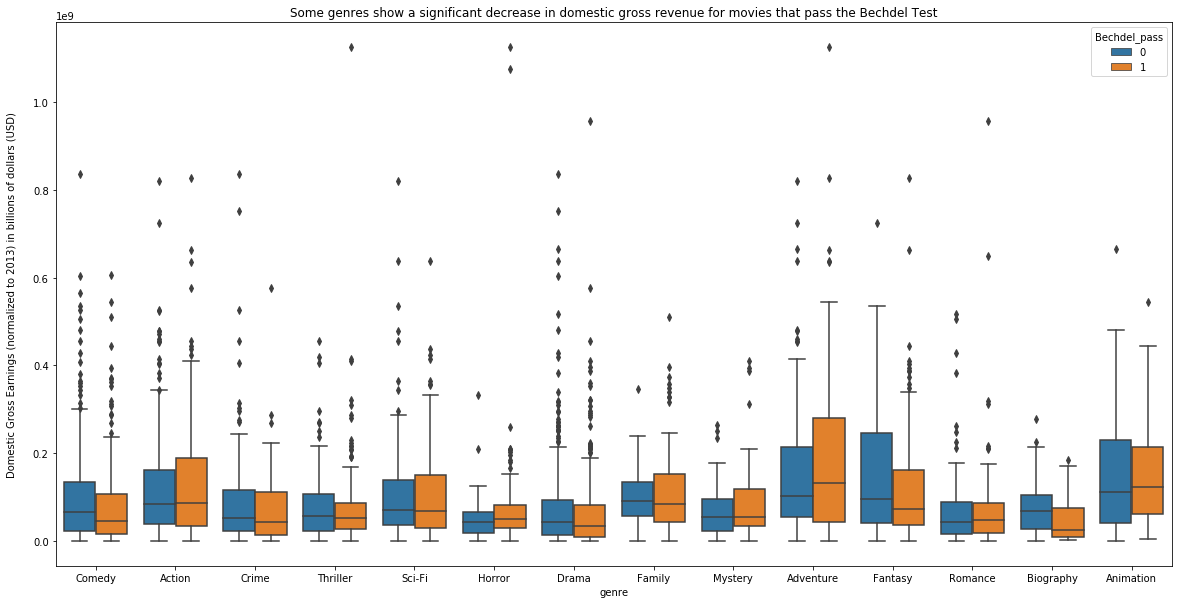

In [37]:
plt.rcParams['figure.figsize'] = [20, 10]
sns.boxplot(x="genre", y="domgross_2013", data=data_moregen, hue='Bechdel_pass').set(
    title = "Some genres show a significant decrease in domestic gross revenue for movies that pass the Bechdel Test",
    ylabel= 'Domestic Gross Earnings (normalized to 2013) in billions of dollars (USD)\n');

Some genres show a significant decrease in audience IMDb ratings for movies that pass the Bechdel Test, below:<a class="anchor" id="aud"></a>

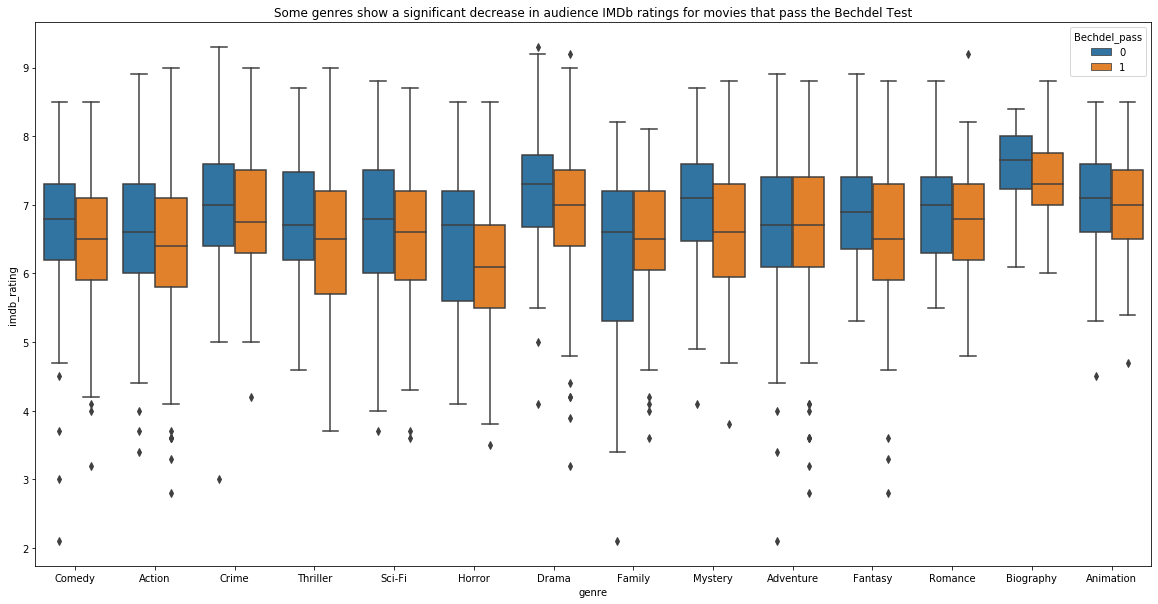

In [38]:
sns.boxplot(x="genre", y="imdb_rating", data=data_moregen, hue='Bechdel_pass').set(
    title = "Some genres show a significant decrease in audience IMDb ratings for movies that pass the Bechdel Test");

In [39]:
## Swap out different genres to see whether there is a significant difference.
genre_test = data_moregen[data_moregen['genre']=='Comedy']

print("Domestic Gross Earnings:\n",
      researchpy.ttest(genre_test['domgross_2013'].loc[genre_test['Bechdel_pass'] <0.5], genre_test['domgross_2013'].loc[genre_test['Bechdel_pass'] > 0.5])[1])
print("\n\nIMDb ratings:\n",
      researchpy.ttest(genre_test['imdb_rating'].loc[genre_test['Bechdel_pass'] <0.5], genre_test['imdb_rating'].loc[genre_test['Bechdel_pass'] > 0.5])[1])

Domestic Gross Earnings:
                               Independent t-test      results
0  Difference (domgross_2013 - domgross_2013) =  29202825.918
1                          Degrees of freedom =       554.000
2                                           t =         3.172
3                       Two side test p value =         0.002
4                      Difference < 0 p value =         0.999
5                      Difference > 0 p value =         0.001
6                                   Cohen's d =         0.272
7                                   Hedge's g =         0.271
8                               Glass's delta =         0.233
9                                 Pearson's r =         0.134


IMDb ratings:
                           Independent t-test  results
0  Difference (imdb_rating - imdb_rating) =     0.236
1                      Degrees of freedom =   557.000
2                                       t =     3.079
3                   Two side test p value =     0.002
4    

## Conclusion: Movies pass the Bechdel Test at different rates based on genre. While the industry as a whole does not experience a meaningful decrease in revenue for movies that pass the Bechdel Test, Comedies, Dramas, and Biographies specifically do.
_________

## Q4. Machine Learning: Can we predict whether a movie will pass the Bechdel test based on the above qualities?<a class="anchor" id="q4"></a>

> ### Random Forest: Classify movies as passing or failing the Bechdel Test based on multiple variables
> * Domestic Gross, normalized to 2013
> * International Gross, normalized to 2013
> * Budget, normalized to 2013
> * Year
> * Metascore (critic reviews)
> * IMDb Rating (user reviews)
> * Film Rating (e.g. "PG-13")
> * Runtime
> * Genre

> ### Model Success = Poor
> * Accuracy = About 60%
> * Area Under the Curve score = About 0.60

**Rationale:**

The random forest was able to predict a movie's Bechdel test classification (pass/fail) slightly better than chance, but the accuracy was not high enough to suggest that the current metrics are robust enough for reliable prediction. This is an unsurprising finding given that the previous explorations showed only weak correlations.

In [40]:
## Import relevant packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from matplotlib.legend_handler import HandlerLine2D

In [41]:
## Prepare the data
# Select relevant columns and remove NaNs
data_nona = data[["domgross_2013", "rated", "imdb_rating", "year",
                  "runtime_min", "budget_2013", "intgross_2013", "metascore", "Bechdel_pass", "genre"]]
data_nona = data_nona.dropna()

# Cast character columns into categories so that they can be converted to numerical values later
cols = ['rated', 'genre']
data_nona[cols] = data_nona[cols].astype('category')
data_nona['rated2'] = data_nona['rated'].cat.rename_categories(list(range(len(data_nona['rated'].value_counts()))))
#data_nona['director2'] = data_nona['director'].cat.rename_categories(list(range(len(data_nona['director'].value_counts()))))
data_nona['genre2'] = data_nona['genre'].cat.rename_categories(list(range(len(data_nona['genre'].value_counts()))))

In [42]:
# Define which columns are predictors
X = data_nona[["domgross_2013", "rated2", "imdb_rating", "year",
               "runtime_min", "budget_2013", "intgross_2013", "metascore", "genre2"]]
y = data_nona[["Bechdel_pass"]]

# Split data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1985
)

Optimize the following parameters by observing a plot comparing different values:
* Optimal "maximum depth" of each tree
* Optimal "number of estimators," or trees

The x-value where the test data's curve begins to plateau is the value to be used in the machine learning model.

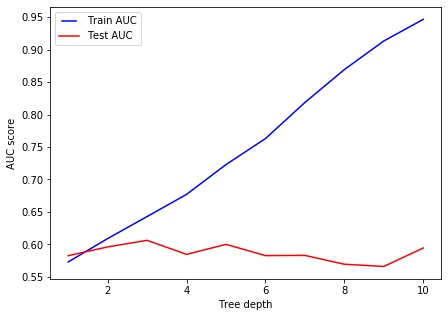

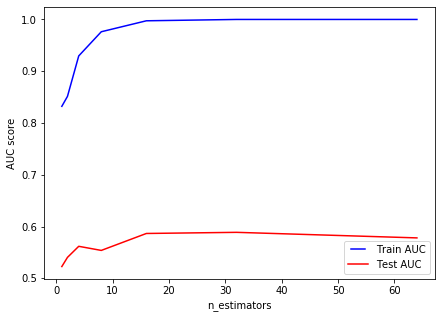

In [43]:
## Determine the optimum depth of each tree in the forest
max_depths = np.linspace(1, 10, 10, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

plt.rcParams['figure.figsize'] = [7, 5]
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()


## Determine the optimum number of estimators, or trees
n_estimators = [1, 2, 4, 8, 16, 32, 64]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(x_train, y_train)
   train_pred = rf.predict(x_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict(x_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

## View the plots and use the value of the x-axis where the curve starts to plateau.

In [44]:
# Create model using random forest, given parameters that are defined by plots at the end
model = RandomForestClassifier(max_depth=3, n_estimators=25)

model.fit(x_train, y_train)

# Predict values for test data
y_pred = model.predict(x_test)

# Evaluate model prediction
print(f"Accuracy is {accuracy_score(y_pred, y_test)*100:.2f} %")

# Evaluate Area Under the Curve as well
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f"Area Under the Curve (AUC) score is {roc_auc:.2f}")

Accuracy is 60.28 %
Area Under the Curve (AUC) score is 0.60


## Conclusion: While movies that pass the Bechdel test share some traits in common, such as typical genres and a tendency to be rated lower, these features are not robust enough to predict a movie's Bechdel test status with reliable accuracy.
_________________________________


# Take-Home Messages & Future Directions<a class="anchor" id="th"></a>

> ### 1. Movies that failed the Bechdel Test may have grossed more in the past, but the difference is largely negligible for more modern releases.
>   A weak trend suggests that movies that pass the Bechdel Test will gross more in the future. This is promising, but given the low bar that the Bechdel Test presents, it does not necessarily mean that viewers are excited to see movies regardless of the cast of characters. Many movies that pass the Bechdel test still contain a majority of male characters, including the protagonist. It would be interesting to see whether movies that do not pass an inverse of the Bechdel Test (that is, fail to include adequate representation of men) would have similar success at the box office.
> ### 2. Movies that passed the Bechdel test are generally rated lower by average viewers, while critics rate them equally to movies that fail the test.
>   In both scenarios, it seems that failing to adequately represent women is not seen as a shortcoming which would negatively impact a movie's ratings. A future analysis could examine whether people of different genders, ages, or political leanings would rate these movies differently.
> ### 3. Of the five genres with the greatest proportion of movies that pass the Bechdel Test, passing Biographies grossed less, and passing Horror and Fantasy films were rated lower.
>   Passing the Bechdel Test at a rate higher than the industry standard did not prevent these three genres from experiencing gender-based inequity in sales and ratings. On the other hand, the genre with the lowest rate of movies to pass the test, Crime, did not experience any significant difference in gross earnings or ratings based on Bechdel Test status. A more in-depth analysis could reveal specific nuances and biases that play a greater role in determining whether a movie that passes the Bechdel test will be well-received in each genre.
> ### 4. Movies that pass the Bechdel Test can be weakly predicted by these and similar attributes via a machine learning model.
>   Given that a small subset of features from the original data set were able to weakly predict a movie's Bechdel status, it seems likely that incorporating more detailed features -- such as the writer, director, and awards won -- would continue to improve the machine learning model. Extracting the features that were most important in creating the model could determine which traits are most common to a movie that passes the Bechdel Test; this could further reveal the areas that should be scrutinized for either promoting or being associated with gender-based inequity.


# Closing Thoughts<a class="anchor" id="ct"></a>

This analysis has revealed many aspects about the modern-day movie industry that can inform real-world decisions.

1. The Bechdel Test quickly **exposes the gender gap** across the entire movie industry. While many gains have been made over the past few decades, the percent of movies that passed the Bechdel Test between 2000-2013 has hovered around 60% rather than continuing to increase. Influencers in the field should continue to assess this metric and push the industry to become more inclusive in the near future. Similar metrics for the inclusion of non-binary and transgender individuals should additionally be assessed.



2. Movie producers should **strive to pass the Bechdel Test** as doing so will not negatively impact their domestic gross earnings or ratings from critics. In fact, there is a possibility that the movie will gross more. Additionally, while audience ratings tend to be lower for movies that pass the Bechdel Test, this is only true for half of the genres featured in the analysis, and it amounts to a difference of no more than an average of 0.5 out of 10 points.

Overall, the trends seem to be heading in a more inclusive direction. Representation in the media is important for people from all demographics, and additional thoughtful analyses can help shed light on areas in which we can continue to improve our efforts towards inclusion.